# A. Data

# 1. Import Packages

In [1]:
import pandas as pd # dataframes
import numpy as np # math
import seaborn as sns # visuals
import PandasToPowerPoint as p2p # make PowerPoints
import calendar # for adding date names
from scipy.stats import f_oneway, ttest_rel # statistics
import matplotlib.pyplot as plt # more visuals (histogram)
import matplotlib as mpl # even more visuals (histogram)
from pptx.enum.dml import MSO_THEME_COLOR # color text based on PPT theme
from pptx.util import Inches, Pt # add Inches for sizing PPT elements
from pptx.enum.text import PP_ALIGN # for aligning text
from pptx.enum.text import MSO_ANCHOR # for anchoring text in table
from matplotlib import style # formatting visual

In [2]:
pd.options.display.max_columns=200
pd.options.display.max_rows=1000
pd.options.display.max_colwidth=500

# 2. User Input

In [3]:
# CHW_CA for Dignity Health
client = "CHW_CA"
old_year_month = "July 2019"
new_year_month = "August 2020"
old_year = rf"\\Mustang\WorkOps_Pub\Pop Health\DataWorks\Data Insights\Client Files\CHW_CA\3. Data\CHW_CA July 2019 All Users.csv"
new_year = rf"\\Mustang\WorkOps_Pub\Pop Health\DataWorks\Data Insights\Client Files\CHW_CA\3. Data\CHW_CA August 2020 All Users.csv"

# 3. Import Data

In [4]:
# import the earlier and newer date tables
df_old = pd.read_csv(old_year,encoding = "ISO-8859-1") # old data
df_new = pd.read_csv(new_year,encoding = "ISO-8859-1") # new data
# stack the old on top of new table
df = pd.concat([
    df_old,
    df_new
])

In [5]:
# check which registries exist in the table
df.registry.unique()

array(['Comprehensive Adult Wellness', 'Diabetes Mellitus'], dtype=object)

### Filter Requested Registries / Measures

In [6]:
# enter registries you want; or replace with 'all'
registries_list = ['Comprehensive Adult Wellness', 'Diabetes Mellitus']
# keep only specified registries
df = df.loc[df['registry'].isin(registries_list)]

In [7]:
# # check which measures exist in the table
# df.measure.unique()

In [8]:
# # enter measures you want; or replace with 'all'
# measures_list = ['Breast Cancer Screening','Colorectal Cancer Screening',
#                 'Depression Screening','Annual Eye Exam','Medical Attention To Nephropathy',
#                 'Bp Less Than 140 90','Depression Screening','Childhood Immunizations',
#                 'Developmental Questionnaire Assessment Age Birth 4 Years']
# # keep only specified registries
# df = df.loc[df['measure'].isin(measures_list)]

# 4. Clean Data

## 4.1 Rename and Drop

In [9]:
# rename columns (for quicker typing)
df.rename(columns = {
    'personnel_id' : 'prsnl'
}, inplace = True)

# drop unneeded columns
#df.drop('fully_qualified_name', axis = 1, inplace = True)

# change this back to original later...
df.loc[:, 'date'] = pd.to_datetime(df.date.copy()).dt.date.astype(str)

In [10]:
# set aside date variables for later
dt_min = df.date.min()
dt_max = df.date.max()

In [11]:
# # keep only specified registries
# df = df.loc[df['registry'].isin(registries_list)]
# # exclude a registry
# #df = df.loc[~df.registry.isin(['Pediatric Ibd'])]
# #df = df.loc[~df.measure.isin(['Influenza Vaccination Given Aug To Mar'])]

## 4.2 Add Columns
### Create 'All' Measure, Registry

#### Measure

In [12]:
# for each date, registry, prsnl, sum num & den
# sum num/den for each registry, date, prsnl
mall = df.groupby([
    'date',
    'registry',
    'prsnl'
]).agg({
    'numerator' : 'sum',
    'denominator' : 'sum'
})

# call it the 'All' measure
mall.insert(mall.shape[1], 'measure', 'All')

#### Registry

In [13]:
# find total numerator/denominator for each provider across date
rall = mall.sum(level = [
    'date',
    'prsnl'
])

# create 'All' registry and measure
rall.loc[:, 'registry'], rall.loc[:, 'measure'] = 'All', 'All'

#### Merge

In [14]:
# reset mall, rall indices and concatenate them together
# 9.24 added 'sort=False'
rmall = pd.concat([
    mall.reset_index(),
    rall.reset_index()
])

In [15]:
# merge rmall with df to have access to 'All' registry and measure
df = df.merge(rmall, how = 'outer', on = rmall.columns.tolist())

# replace client NaN with first client listed (should all be the same)
#df.client = df.client.unique()[0]
df.client = client

In [16]:
# create measure met column
df["met"] = df["numerator"] / df["denominator"]

In [17]:
# make the "data" dataframe from df
data = df

# B. Current State

## 1. Add Stats Table

### 1.1 Make Bible

In [18]:
# requires one row per 
def bible(x, col):
#     make dictionary of functions
    d = {}
#     count
    d['count'] = x[col].count()
#     standard deviation
    d['std'] = x[col].std()
#     median
    d['median'] = x[col].median()
#     mean
    d['mean'] = x[col].mean()
#     variance
    d['var'] = x[col].var()
#     lower confidence interval
    d['lci'] = x[col].mean() - 1.96 * x[col].std() / np.sqrt(len(x))
#     upper confidence interval
    d['uci'] = x[col].mean() + 1.96 * x[col].std() / np.sqrt(len(x))
#     score
    d['score'] = x[col].std() + (1 + x[col].mean()) * 100
#     sum of numerator
    d['numerator_sum'] = x.numerator.sum()
#     sum of denominator
    d['denominator_sum'] = x.denominator.sum()
    
    return pd.Series(d, index = [
        'mean',
        'std',
        'lci',
        'uci',
        'count',
        'median',
        'var',
        'score',
        'numerator_sum',
        'denominator_sum'
    ])

### 1.2 Apply Bible

In [19]:
# apply the bible and call it the stats table
stats_table = df.groupby([
    'date',
    'registry',
    'measure'
]).apply(bible, 'met')

In [20]:
# add total_measure_met
stats_table['total_measure_met'] = stats_table.numerator_sum / stats_table.denominator_sum

In [21]:
# specify column order
reorderlist = ['mean', 'std', 'lci', 'uci', 'count', 'median', 'var', 'score', 'numerator_sum', 'denominator_sum', 'total_measure_met']

# unstack date and sort index (for viewing only)
stat_unstack = stats_table.unstack('date').swaplevel(1, 0, axis = 1).sort_index(axis = 1).reindex(columns=reorderlist,level=1)

In [22]:
# subtract means, subtract total_measure_mets
stat_unstack['change_of_means'], stat_unstack['change_total_measure_met'] = stat_unstack[dt_max]['mean'] - stat_unstack[dt_min]['mean'], stat_unstack[dt_max]['total_measure_met'] - stat_unstack[dt_min]['total_measure_met']
stat_unstack['change_of_std'], stat_unstack['change_total_measure_met'] = stat_unstack[dt_max]['std'] - stat_unstack[dt_min]['std'], stat_unstack[dt_max]['total_measure_met'] - stat_unstack[dt_min]['total_measure_met']

## 2. Make Current State

In [23]:
# Current State Slide per Registry
cs = stat_unstack[dt_max]
# Drop rows with NAs
cs = cs.dropna(how='any',axis=0)
# format
cs["conf_int"] = '('+((cs['lci'])*100).round(1).astype(str) + '%' + ' - ' + ((cs['uci'])*100).round(1).astype(str) + '%' +')'
cs['mean'] = ((cs['mean'])*100).round(1).astype(str) + '%'
cs['std'] = ((cs['std'])*100).round(1).astype(str) + '%'
cs['count'] = cs['count'].astype(int)
# drop unneeded columns
cs = cs[[
    "count",
    "mean",
    "conf_int",
    "std"
]]
# rename columns
cs.rename(columns={"count":"Providers","mean":"Measure Met","conf_int":"95% Confidence Interval","std":"Standard Deviation"},inplace=True)
cs = cs.reset_index()
cs.columns = cs.columns.str.title()
current_state = cs

# C. Trending

## C.1 Intersect Personnel
Make a table where only prsnl who appear in both old and new dates are kept

In [24]:
# drop registry, measure, prsnl without both dates
intersect = df.groupby([
    'registry',
    'measure',
    'prsnl',
    'date'
]).agg({
    'date' : 'max'
}).unstack('date').dropna().stack('date').index.to_frame().reset_index(drop = True)

# merge df with intersection
df_i = df.merge(intersect, how = 'inner', on = [
    'registry',
    'measure',
    'prsnl',
    'date'
])

## C.2 Stats Table for Intersection

In [25]:
# apply the bible and call it stats table intersection
stats_table_i = df_i.groupby([
    'date',
    'registry',
    'measure'
]).apply(bible, 'met')

# add total_measure_met
stats_table_i['total_measure_met'] = stats_table_i.numerator_sum / stats_table_i.denominator_sum

# unstack date and sort index (for viewing only)
stat_unstack_i = stats_table_i.unstack('date').swaplevel(1, 0, axis = 1).sort_index(axis = 1)

# subtract means, subtract total_measure_mets
#stat_unstack_i['change_of_means'], stat_unstack_i['change_total_measure_met'] = stat_unstack_i[str(df.date.max())]['mean'] - stat_unstack_i[str(df.date.min())]['mean'], stat_unstack_i[str(df.date.max())]['total_measure_met'] - stat_unstack_i[str(df.date.min())]['total_measure_met']
stat_unstack_i['change_of_means'], stat_unstack_i['change_total_measure_met'] = stat_unstack_i[str(df.date.max())]['mean'] - stat_unstack_i[str(df.date.min())]['mean'], (stat_unstack_i[str(df.date.max())]['total_measure_met']*100).round(1) - (stat_unstack_i[str(df.date.min())]*100).round(1)['total_measure_met']
# stat_unstack_i

## C.3 Rearrange

In [26]:
reorderlist = ['mean','std','uci','lci','count']
df_format_i = stats_table_i.unstack('date').swaplevel(1, 0, axis = 1).sort_index(axis = 1).reindex(columns=reorderlist,level=1).stack(level=1)
#
df_format_i['stat']= df_format_i[dt_max] - df_format_i[dt_min]

df_format_i = df_format_i.unstack()

df_format_i = df_format_i.swaplevel(1, 0, axis = 1)

df_format_i = df_format_i.stack(level=1)
df_format_i["conf_int"] = '('+((df_format_i['lci'])*100).round(1).astype(str) + '%' + ' - ' + ((df_format_i['uci'])*100).round(1).astype(str) + '%' +')'

df_format_i['df'] = df_format_i['count'].astype('int') - 1
#df_format_i['mean'] = ((df_format_i['mean'])*100).round(1).astype(str) + '%'
#df_format_i['std'] = ((df_format_i['std'])*100).round(1).astype(str) + '%'
#
df_format_i = df_format_i[["mean","std","conf_int","df"]].unstack().swaplevel(1, 0, axis = 1).sort_index(axis = 1)
#
reorder = ['mean', 'std', 'conf_int', 'df']

drops = [
    ('stat','df'),
    ('stat','conf_int'),
    (dt_min,'df')
]
table = df_format_i.drop(drops, axis=1).reindex(columns=reorder,level=1)

#
# subset indexes
dates_df = table[[dt_min,dt_max]]
deg_fr = dates_df[dt_max][["df"]]
change_df = table[["stat"]]
change_df = change_df["stat"][["mean","std"]].merge(dates_df[dt_max][["df"]],left_index=True,right_index=True)
change_df = change_df.rename(columns = {"mean":"mean_change","std":"std_change"})
dates_df = dates_df.drop(columns='df',level=1)

# Excellent
dates_df.join(pd.concat([change_df],axis=1, keys=["stat"],names=['date'])) # alternative options
combined_i = dates_df.sort_index(axis = 1,level = 1).join(pd.concat([change_df],axis=1, keys=["stat"],names=['date']))
combined_i.head(1)

date             2019-07-01 2020-08-01 2019-07-01 2020-08-01       2019-07-01  \
                       mean       mean        std        std         conf_int   
registry measure                                                                
All      All       0.503739   0.513192   0.151479   0.139593  (48.8% - 51.9%)   

date                   2020-08-01        stat                  
                         conf_int mean_change std_change   df  
registry measure                                               
All      All      (49.9% - 52.8%)    0.009453  -0.011886  359

In [27]:
# clean column names
combined_i.columns = ['_'.join(col).strip() for col in combined_i.columns.values]
combined_i.columns = combined_i.columns.str.replace("stat_","")

In [28]:
# call the table "trending"
trending = combined_i

# D. T-Test

## D.1 Stat Tests

### D.1.1 T & F Test Function

In [29]:
def stat_test(x, date_1, date_2, test = 't'):
#     make dictionary of functions
    d = {}
    if test == 't':
#         perform t-test
        t_test = ttest_rel(x[date_1], x[date_2])
    #     get t-statistic
        d['t_stat'] = t_test[0]
    #     get p-value
        d['p_value'] = t_test[1]
#         return results
        return pd.Series(d, index = [
            't_stat',
            'p_value'
        ])
    elif test == 'f':
#         perform f-test
        f_test = f_oneway(x[date_1], x[date_2])
#         get f-statistic
        d['f_stat'] = f_test[0]
#         get p-value
        d['p_value'] = f_test[1]
#         return results
        return pd.Series(d, index = [
            'f_stat',
            'p_value'
        ])

### D.1.2 T-Test

In [30]:
test = df_i.pivot_table(index = [
    'registry',
    'measure',
    'prsnl'
], columns = 'date', values = 'met', aggfunc = 'max').reset_index()

test.columns = test.columns.astype(str)

test_g = test.groupby([
    'registry',
    'measure'
])

t_test = test_g.apply(stat_test, str(df_i.date.min()), str(df_i.date.max()), test = 't')
t_test["sig"] = np.where(t_test.p_value>=0.05,0,1)

# E. Formatted

In [31]:
# join t_test to trending
full_i = trending.join(t_test)

In [32]:
# # create analysis sentence
full_i["analysis"] = np.where(full_i.p_value>=0.05,
                              np.where(full_i.mean_change<0,"a decrease","an increase"),
                              np.where(full_i.mean_change<0,"a significant decrease","a significant increase"))
full_i["analysis"] = "There was " + full_i.analysis.astype(str) + " of " + abs(((full_i[dt_min+"_mean"] - full_i[dt_max+"_mean"])*100).round(1)).astype(str) + "% MM across " + (full_i["df"]+1).astype(int).astype(str) + " providers while standard deviation " + np.where(full_i.std_change>0,"increased ","decreased ") + abs(((full_i[dt_min+"_std"] - full_i[dt_max+"_std"])*100).round(1)).astype(str) +"%"

In [33]:
full_i["sig_text"] = np.where(full_i.p_value<0.05,"a significant",
                              np.where(full_i.mean_change<0,"a","an"))
full_i["direction_text"] = np.where(full_i.mean_change<0,"decrease","increase")

full_i["initial_text"] = "There was " + full_i.sig_text + " "

In [34]:
full_i["change_text"] = full_i.direction_text.astype(str) + " of " + abs(((full_i[dt_min+"_mean"] - full_i[dt_max+"_mean"])*100).round(1)).astype(str) + "%"

In [35]:
full_i["final_text"] = "MM across " + (full_i["df"]+1).astype(int).astype(str) + " providers while standard deviation " + np.where(full_i.std_change>0,"increased ","decreased ") + abs(((full_i[dt_min+"_std"] - full_i[dt_max+"_std"])*100).round(1)).astype(str) +"%"

In [36]:
# Reorder the columns for easy copy/paste later
formatted_i = full_i[[
    "analysis",
    dt_min+"_mean",
    dt_max+"_mean",
    dt_min+"_std",
    dt_max+"_std",
    dt_min+"_conf_int",
    dt_max+"_conf_int",
    "t_stat",
    "df",
    "p_value",
    "initial_text",
    "change_text",
    "final_text"
]]

# Format columns
formatted_i[dt_min+"_mean"] = (formatted_i[dt_min+"_mean"]*100).round(1).astype(str) + '%'
formatted_i[dt_max+"_mean"] = (formatted_i[dt_max+"_mean"]*100).round(1).astype(str) + '%'
formatted_i[dt_min+"_std"] = (formatted_i[dt_min+"_std"]*100).round(1).astype(str) + '%'
formatted_i[dt_max+"_std"] = (formatted_i[dt_max+"_std"]*100).round(1).astype(str) + '%'
formatted_i["t_stat"] = "t-stat: " + formatted_i.t_stat.round(4).map(str)
formatted_i["p_value"] = np.where(formatted_i["p_value"]>=0.05,formatted_i["p_value"].round(2).astype(str)+'*',"<0.05")
formatted_i["p_value"] = "p-value: " + formatted_i.p_value.map(str)
formatted_i["df"] = "df: " + formatted_i.df.map(str)

C:\Users\JM025575\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\JM025575\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\JM025575\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [37]:
formatted = formatted_i

# Export to Excel

In [38]:
data.head(1)

,client,date,prsnl,registry,fully_qualified_name,measure,numerator,denominator,met
0,CHW_CA,2019-07-01,Aarohi Munshi,Comprehensive Adult Wellness,cernerstandard.comprehensiveadultwellness.clinical/breast-cancer-screening,Breast Cancer Screening,17,53,0.320755


In [39]:
current_state.tail(1)

,Registry,Measure,Providers,Measure Met,95% Confidence Interval,Standard Deviation
14,Diabetes Mellitus,Statin Therapy Generic Diabetic Group,313,70.7%,(69.4% - 71.9%),11.1%


In [40]:
trending.head(1)

,,2019-07-01_mean,2020-08-01_mean,2019-07-01_std,2020-08-01_std,2019-07-01_conf_int,2020-08-01_conf_int,mean_change,std_change,df
registry,measure,,,,,,,,,
All,All,0.503739,0.513192,0.151479,0.139593,(48.8% - 51.9%),(49.9% - 52.8%),0.009453,-0.011886,359


In [41]:
t_test.head(1)

,,t_stat,p_value,sig
registry,measure,,,
All,All,-1.310785,0.190768,0


In [42]:
formatted.head(1)

,,analysis,2019-07-01_mean,2020-08-01_mean,2019-07-01_std,2020-08-01_std,2019-07-01_conf_int,2020-08-01_conf_int,t_stat,df,p_value,initial_text,change_text,final_text
registry,measure,,,,,,,,,,,,,
All,All,There was an increase of 0.9% MM across 360 providers while standard deviation decreased 1.2%,50.4%,51.3%,15.1%,14.0%,(48.8% - 51.9%),(49.9% - 52.8%),t-stat: -1.3108,df: 359,p-value: 0.19*,There was an,increase of 0.9%,MM across 360 providers while standard deviation decreased 1.2%


In [43]:
# extract max date and min date names
dt_max_name = dt_max.replace(dt_max,calendar.month_name[int(dt_max[5:7])]+' '+dt_max[0:4])
dt_min_name = dt_min.replace(dt_min,calendar.month_name[int(dt_min[5:7])]+' '+dt_min[0:4])

In [44]:
excel_save_path = f"{client}_excel_output_{dt_min_name}_{dt_max_name}14MoAll.xlsx"
writer = pd.ExcelWriter(path = excel_save_path, engine = 'xlsxwriter')
data.to_excel(writer, sheet_name = 'Data')
current_state.to_excel(writer, sheet_name = 'Current State')
trending.to_excel(writer, sheet_name = 'Trending')
t_test.to_excel(writer, sheet_name = 'T-Test')
formatted.to_excel(writer, sheet_name = 'Formatted')
writer.save()

# Format Trending Table

In [45]:
# rename dates to month_name year
dt_name_cols = [dt_min_name,dt_max_name]

# F. Powerpoint

### Make Analysis

In [46]:
# make table with t_test, registry, measure
slide_t_test = t_test.loc[registries_list, :].dropna()

# format
stat_t = round((stat_unstack_i.loc[:, (slice(None), [
    'count',
    'lci',
    'mean',
    'std',
    'uci'
])]), 3).copy().stack('date').reset_index(level = 'date')

# add t_stat and p_value
stat_t['t_stat'], stat_t['p_value'] = round(slide_t_test.t_stat.copy(), 5), round(slide_t_test.p_value.copy(), 5)

# add significance indicator and difference
stat_t['significant'], stat_t['difference'] = stat_t.p_value.copy() < 0.05, round(stat_t.loc[stat_t.date == stat_t.date.max(), 'mean'].copy() - stat_t.loc[stat_t.date == stat_t.date.min(), 'mean'].copy(), 3)

stat_t.dropna(inplace = True)

In [47]:
# define histogram dataframe
h = df_i[(df_i.registry != 'All') & (df_i.measure != 'All')].pivot_table(index = [
    'registry',
    'measure',
    'prsnl'
], columns = 'date', values = 'met').reset_index(level = 'prsnl', drop = True)

# define bins
bins = [x/100 for x in range(0, 101, 5)]

## Cerner Colors

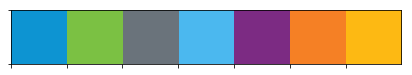

In [48]:
cerner_colors = ['#0d94d2', # Blue
                 '#7bc143', # Green
                 '#6a737b', # Grey
                 '#4bb8ef', # Cyan
                 '#7c2b83', # Purple
                 '#f58025', # Orange
                 '#fdb913'] # Yellow

# Set current color palette
sns.set_palette(cerner_colors)

# Show color palette
sns.palplot(sns.color_palette()) 

### PPT Styles

In [49]:
medium_3_accent_5 = "{74C1A8A3-306A-4EB7-A6B1-4F7E0EB9C5D6}"

## Test with one registry & measure (as needed)

In [50]:
# # pick first fqn and use it to set registry and measure for one slide
# fqn = df.fully_qualified_name.unique()[0]
# reg = df.loc[df.fully_qualified_name==fqn].registry.unique()[0]
# meas = df.loc[df.fully_qualified_name==fqn].measure.unique()[0]

In [51]:
# # open pptx from Cerner Standard Template
# prs = p2p.Presentation(r"\\mustang\workops_pub\Pop Health\DataWorks\Data Insights\Personal Working Folders\Ian\PowerPoint Templates\Cerner Standard v5.pptx".replace('\\','/'))
# #############################
# ## CREATE REGISTRY DIVIDER ##
# #############################

# # select Blue Divider from Slide Master
# primary_content = prs.slide_layouts[6]

# # add slide
# slide = prs.slides.add_slide(primary_content)

# ############################
# ## TITLE REGISTRY DIVIDER ##
# ############################

# # select title box
# title_box = slide.shapes[0]
# text_frame = title_box.text_frame
# p = text_frame.paragraphs[0]

# # add registry, then bold & color
# run = p.add_run()
# run.text = reg
# font = run.font
# font.bold = True

# ###################################
# ## CREATE REGISTRY SUMMARY SLIDE ##
# ###################################

# # save slide from layout 2 in Slide Master
# primary_content = prs.slide_layouts[2]

# # add slide
# slide = prs.slides.add_slide(primary_content)

# ####################
# ## TITLE RS SLIDE ##
# ####################

# # select title box
# title_box = slide.shapes[0]
# text_frame = title_box.text_frame
# p = text_frame.paragraphs[0]
# # add registry, then bold & color
# run = p.add_run()
# run.text = reg
# font = run.font
# font.bold = True
# font.color.theme_color = MSO_THEME_COLOR.ACCENT_1
# # add text
# run = p.add_run()
# run.text = " Provider Performance"

# #####################
# ## CREATE RS TABLE ##
# #####################

# ## Make Registry Summary Table from "Current State" dataframe
# reg_summary = cs.loc[cs.Registry==reg]
# reg_summary = reg_summary.loc[reg_summary.Measure!="All"]
# reg_summary.drop(columns="Registry",inplace=True)

# # assign to "my_table" variable
# my_table = reg_summary

# # convert column names to titlecase
# my_table.columns = my_table.columns.str.title()

# rows, columns = my_table.shape
# #### Create Table Slide 1 ####
# shapes = slide.shapes
# table_placeholder = slide.shapes[1]
# shape = table_placeholder.insert_table(rows=rows+1, cols=columns)
# table = shape.table

# ##################
# # TITLE RS TABLE #
# ##################

# # loop through all columns in df and insert as 0th row
# for col in range(columns):
#     cell = table.cell(0,col)
#     p = cell.text_frame.paragraphs[0]
#     # add the tier name in bold
#     run = p.add_run()
#     # add text from table columns
#     run.text = my_table.columns[col]
#     # center and middle text
#     cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
#     cell.vertical_anchor = MSO_ANCHOR.MIDDLE

# #################
# # FILL RS TABLE #
# #################

# # look through all values in table (exluding 0th row)
# m = my_table.values
# for row in range(rows):
#         for col in range(columns):
#             val = m[row, col]
#             cell = table.cell(row+1,col)
#             p = cell.text_frame.paragraphs[0]
#             # add the tier name in bold
#             run = p.add_run()
#             # add text from table, accounting for name row
#             run.text = str(my_table.iloc[row,col])
#             # Middle all text; Left align if measure, otherwise center
#             cell.vertical_anchor = MSO_ANCHOR.MIDDLE
#             if col is 0:
#                     cell.text_frame.paragraphs[0].alignment = PP_ALIGN.LEFT
#             else:
#                 cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER

# # format table style
# tbl =  shape._element.graphic.graphicData.tbl
# style_id = medium_3_accent_5
# tbl[0][-1].text = style_id

# ############################
# ## CREATE TRENDING SLIDES ##
# ############################

# # save slide from layout 9 in Slide Master
# primary_content = prs.slide_layouts[0]

# # add slide
# slide1 = prs.slides.add_slide(primary_content)
# # add slide 2
# slide2 = prs.slides.add_slide(primary_content)

# trending_slides = [slide1, slide2]

# ##############################
# ## CREATE TRENDING TABLE DF ##
# ##############################

# # make table
# ttable = formatted.reset_index()
# slicet = ttable.loc[(ttable["measure"]==meas) & (ttable["registry"]==reg)]
# means = slicet[[dt_min+"_mean",dt_max+"_mean"]]
# stds = slicet[[dt_min+"_std",dt_max+"_std"]]
# conf_ints = slicet[[dt_min+"_conf_int",dt_max+"_conf_int"]]
# stats_r = slicet[["t_stat","df","p_value"]]
# # columns
# means.columns = dt_name_cols
# stds.columns = dt_name_cols
# conf_ints.columns = dt_name_cols
# stats_r.columns = [""]+dt_name_cols
# # formatting
# means.insert(0,"",['Mean Met %'])
# stds.insert(0,"",['Standard Dev.'])
# conf_ints.insert(0,"",['95% CI'])
# table_for_trend = pd.concat([means,stds,conf_ints,stats_r])

# # assign to "my_table" variable
# my_table = table_for_trend

# # convert column names to titlecase
# my_table.columns = my_table.columns.str.title()

# rows, columns = my_table.shape

# ######################
# ## CREATE HISTOGRAM ##
# ######################

# # make figure, plot
# fig1, ax1 = plt.subplots(figsize = (5, 5))
# # create plot
# h.loc[(reg, meas)].plot.hist(ax = ax1, bins = bins, **{
#     'alpha' : 0.6
# }, color = [cerner_colors[0], cerner_colors[1]]).xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax = 1))
# #             remove y-label
# ax1.set_ylabel('')
# #             change font size of ticks
# ax1.tick_params(axis = 'both', labelsize = 10, pad = 2.5)
# #             set legend
# ax1.legend(loc = 'upper left', prop = {
#     'size' : 10
# })
# ax1.grid(axis='x')
# #             save figure
# fig1.savefig('hist_fig.png', dpi = 500)
# #             close fig
# plt.close(fig1)

# #########
# ## KDE ##
# #########

# #             make figure, plot
# fig2, ax2 = plt.subplots(figsize = (5, 5))
# #             create plot
# sns.distplot(ax = ax2, a = h.loc[(reg, meas), h.columns[0]], color = cerner_colors[0], bins = bins, hist = False, label = h.columns[0])
# sns.distplot(ax = ax2, a = h.loc[(reg, meas), h.columns[1]], color = cerner_colors[1], bins = bins, hist = False, label = h.columns[1]).xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax = 1))
# #             remove x-label
# ax2.set_xlabel('')
# #             set x-lim
# ax2.set_xlim(xmin = 0, xmax = 1)
# #             change font size of ticks
# ax2.tick_params(axis = 'both', labelsize = 10, pad = 2.5)
# #             set legend
# ax2.legend(loc = 'upper left', prop = {
#     'size' : 10
# })
# ax2.grid(axis='x')
# #             save figure
# fig2.savefig('kde_fig.png', dpi = 500)
# #             close fig
# plt.close(fig2)

# for slide in trending_slides:
    
#     ###########
#     ## TITLE ##
#     ###########

#     ## Slide 1
#     # select title box
#     title_box = slide.shapes[0]
#     text_frame = title_box.text_frame
#     p = text_frame.paragraphs[0]

#     # add registry, then bold & color
#     run = p.add_run()
#     run.text = reg
#     font = run.font
#     font.bold = True
#     font.color.theme_color = MSO_THEME_COLOR.ACCENT_1

#     # add measure
#     run = p.add_run()
#     run.text = " "+meas
#     font = run.font

#     ###################
#     ## ANALYSIS TEXT ##
#     ###################
#     # Slide 1
#     # select text box
#     title_box = slide.shapes[1]
#     text_frame = title_box.text_frame
#     p = text_frame.paragraphs[0]
#     # add initial text
#     run = p.add_run()
#     run.text = formatted.loc[(reg,meas),"initial_text"]
#     font = run.font
#     # add change text
#     run = p.add_run()
#     run.text = formatted.loc[(reg,meas),"change_text"]
#     font = run.font
#     if table_for_trend.iloc[3,2] == 'p-value: <0.05':
#         font.bold = True
#         font.color.theme_color = MSO_THEME_COLOR.ACCENT_1
#     # add final text
#     run = p.add_run()
#     run.text = " "+ formatted.loc[(reg,meas),"final_text"]
#     font = run.font

#     ################
#     # CREATE TABLE #
#     ################    
#     shapes = slide.shapes
#     table_placeholder = slide.shapes[2]
#     shape = table_placeholder.insert_table(rows=rows+1, cols=columns)
#     table = shape.table

#     ###############
#     # TITLE TABLE #
#     ###############

#     # loop through all columns in df and insert as 0th row
#     for col in range(columns):
#         cell = table.cell(0,col)
#         p = cell.text_frame.paragraphs[0]
#         # add the tier name in bold
#         run = p.add_run()
#         # add text from table columns
#         run.text = my_table.columns[col]
#         # center and middle text
#         cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
#         cell.vertical_anchor = MSO_ANCHOR.MIDDLE

#     ##############
#     # FILL TABLE #
#     ##############

#     # look through all values in table (exluding 0th row)
#     m = my_table.values
#     for row in range(rows):
#             for col in range(columns):
#                 val = m[row, col]
#                 cell = table.cell(row+1,col)
#                 p = cell.text_frame.paragraphs[0]
#                 # add the text as run
#                 run = p.add_run()
#                 # add text from table, accounting for name row
#                 run.text = str(my_table.iloc[row,col])
#                 # Middle & Center all text
#                 cell.vertical_anchor = MSO_ANCHOR.MIDDLE
#                 cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
#                 if col is 0:
#                     # bold
#                     font = run.font
#                     font.bold = True

#     # make sure t-stat isn't bolded
#     cell = table.cell(4,0)
#     p = cell.text_frame.paragraphs[0]
#     # add text from table
#     p.text = str(my_table.iloc[3,0])
#     # # Middle & Center all text
#     # cell.vertical_anchor = MSO_ANCHOR.MIDDLE
#     # cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
#     # no bold bold
#     font = p.font
#     font.bold = False

#     # format table style
#     tbl =  shape._element.graphic.graphicData.tbl
#     style_id = medium_3_accent_5
#     tbl[0][-1].text = style_id

#     #######################
#     ## SIGNIFICANCE TEXT ##
#     #######################

#     # Add qualifying text if 'not significant'...otherwise remove placeholder object
#     if table_for_trend.iloc[3,2] == 'p-value: <0.05':
#         cp = slide.shapes[3]
#         cp.element.getparent().remove(cp.element)
#     else: 
#         sig_text='*not statistically significant'
#         slide.shapes[3].text = sig_text

# ############################
# ## INSERT HISTOGRAM & KDE ##
# ############################

# # insert Histogram
# slide1.shapes[4].insert_picture('hist_fig.png')

# # insert KDE
# slide2.shapes[4].insert_picture('kde_fig.png')

# ##########
# ## SAVE ##
# ##########
# # save pptx
# prs.save(f"{client}_test_one_measure.pptx")
# print(f"Finished {reg},{meas}")
# print("Done!")

# Loop Through All Measures

To-Do:
* Bold and Blue Registry
* Bold and Blue "increase of X" or "decrease of X" for significant measures
* Format Table (grey) [Medium 2 Accent 2?]
* Center text in table
* make sure empty boxes drop

In [52]:
# open pptx from Cerner Standard Template
prs = p2p.Presentation(r"\\mustang\workops_pub\Pop Health\DataWorks\Data Insights\Personal Working Folders\Ian\PowerPoint Templates\Cerner Standard v5.pptx".replace('\\','/'))

############ ############ ############ 
# REGISTRY # # REGISTRY # # REGISTRY # 
############ ############ ############ 
# For each Registry in the dataset...
for reg in stat_t.index.get_level_values(0).unique():

    #############################
    ## CREATE REGISTRY DIVIDER ##
    #############################

    # select Blue Divider from Slide Master
    primary_content = prs.slide_layouts[6]

    # add slide
    slide = prs.slides.add_slide(primary_content)

    ############################
    ## TITLE REGISTRY DIVIDER ##
    ############################

    # select title box
    title_box = slide.shapes[0]
    text_frame = title_box.text_frame
    p = text_frame.paragraphs[0]

    # add registry, then bold & color
    run = p.add_run()
    run.text = reg
    font = run.font
    font.bold = True

    ###################################
    ## CREATE REGISTRY SUMMARY SLIDE ##
    ###################################

    # save slide from layout 2 in Slide Master
    primary_content = prs.slide_layouts[2]

    # add slide
    slide = prs.slides.add_slide(primary_content)

    ####################
    ## TITLE RS SLIDE ##
    ####################

    # select title box
    title_box = slide.shapes[0]
    text_frame = title_box.text_frame
    p = text_frame.paragraphs[0]
    
    # add registry, then bold & color
    run = p.add_run()
    run.text = reg
    font = run.font
    font.bold = True
    font.color.theme_color = MSO_THEME_COLOR.ACCENT_1
    
    # add text
    run = p.add_run()
    run.text = " Provider Performance"

    #####################
    ## CREATE RS TABLE ##
    #####################

    ## Make Registry Summary Table from "Current State" dataframe
    reg_summary = cs.loc[cs.Registry==reg]
    reg_summary = reg_summary.loc[reg_summary.Measure!="All"]
    reg_summary.drop(columns="Registry",inplace=True)

    # assign to "my_table" variable
    my_table = reg_summary

    # convert column names to titlecase
    my_table.columns = my_table.columns.str.title()

    rows, columns = my_table.shape
    #### Create Table Slide 1 ####
    shapes = slide.shapes
    table_placeholder = slide.shapes[1]
    shape = table_placeholder.insert_table(rows=rows+1, cols=columns)
    table = shape.table

    ##################
    # TITLE RS TABLE #
    ##################

    # loop through all columns in df and insert as 0th row
    for col in range(columns):
        cell = table.cell(0,col)
        p = cell.text_frame.paragraphs[0]
        # add the tier name in bold
        run = p.add_run()
        # add text from table columns
        run.text = my_table.columns[col]
        # center and middle text
        cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
        cell.vertical_anchor = MSO_ANCHOR.MIDDLE

    #################
    # FILL RS TABLE #
    #################

    # look through all values in table (exluding 0th row)
    m = my_table.values
    for row in range(rows):
            for col in range(columns):
                val = m[row, col]
                cell = table.cell(row+1,col)
                p = cell.text_frame.paragraphs[0]
                # add the tier name in bold
                run = p.add_run()
                # add text from table, accounting for name row
                run.text = str(my_table.iloc[row,col])
                # Middle all text; Left align if measure, otherwise center
                cell.vertical_anchor = MSO_ANCHOR.MIDDLE
                if col is 0:
                        cell.text_frame.paragraphs[0].alignment = PP_ALIGN.LEFT
                else:
                    cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER

    # format table style
    tbl =  shape._element.graphic.graphicData.tbl
    style_id = medium_3_accent_5
    tbl[0][-1].text = style_id
    ############     ############     ############ 
    # MEASURES #     # MEASURES #     # MEASURES #
    ############     ############     ############
    # For each Measure in the dataset...
    for meas in stat_t.loc[reg].index.unique():
        if meas != 'All':
            ############################
            ## CREATE TRENDING SLIDES ##
            ############################

            # save slide from layout 9 in Slide Master
            primary_content = prs.slide_layouts[0]

            # add slide
            slide1 = prs.slides.add_slide(primary_content)
            # add slide 2
            slide2 = prs.slides.add_slide(primary_content)

            trending_slides = [slide1, slide2]
            
            ##############################
            ## CREATE TRENDING TABLE DF ##
            ##############################

            # make table
            ttable = formatted.reset_index()
            slicet = ttable.loc[(ttable["measure"]==meas) & (ttable["registry"]==reg)]
            means = slicet[[dt_min+"_mean",dt_max+"_mean"]]
            stds = slicet[[dt_min+"_std",dt_max+"_std"]]
            conf_ints = slicet[[dt_min+"_conf_int",dt_max+"_conf_int"]]
            stats_r = slicet[["t_stat","df","p_value"]]
            
            # columns
            means.columns = dt_name_cols
            stds.columns = dt_name_cols
            conf_ints.columns = dt_name_cols
            stats_r.columns = [""]+dt_name_cols
            
            # formatting
            means.insert(0,"",['Mean Met %'])
            stds.insert(0,"",['Standard Dev.'])
            conf_ints.insert(0,"",['95% CI'])
            table_for_trend = pd.concat([means,stds,conf_ints,stats_r])

            # assign to "my_table" variable
            my_table = table_for_trend

            # convert column names to titlecase
            my_table.columns = my_table.columns.str.title()
            
            # create 'rows' & 'columns' variables for later use
            rows, columns = my_table.shape

            ######################
            ## CREATE HISTOGRAM ##
            ######################

            # make figure, plot
            fig1, ax1 = plt.subplots(figsize = (5, 5))
            # create plot
            h.loc[(reg, meas)].plot.hist(ax = ax1, bins = bins, **{
                'alpha' : 0.6
            }, color = [cerner_colors[0], cerner_colors[1]]).xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax = 1))
            #             remove y-label
            ax1.set_ylabel('')
            #             change font size of ticks
            ax1.tick_params(axis = 'both', labelsize = 10, pad = 2.5)
            #             set legend
            ax1.legend(loc = 'upper left', prop = {
                'size' : 10
            })
            ax1.grid(axis='x')
            #             save figure
            fig1.savefig('hist_fig.png', dpi = 500)
            #             close fig
            plt.close(fig1)

            ################
            ## CREATE KDE ##
            ################

            #             make figure, plot
            fig2, ax2 = plt.subplots(figsize = (5, 5))
            #             create plot
            sns.distplot(ax = ax2, a = h.loc[(reg, meas), h.columns[0]], color = cerner_colors[0], bins = bins, hist = False, label = h.columns[0])
            sns.distplot(ax = ax2, a = h.loc[(reg, meas), h.columns[1]], color = cerner_colors[1], bins = bins, hist = False, label = h.columns[1]).xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax = 1))
            #             remove x-label
            ax2.set_xlabel('')
            #             set x-lim
            ax2.set_xlim(xmin = 0, xmax = 1)
            #             change font size of ticks
            ax2.tick_params(axis = 'both', labelsize = 10, pad = 2.5)
            #             set legend
            ax2.legend(loc = 'upper left', prop = {
                'size' : 10
            })
            ax2.grid(axis='x')
            #             save figure
            fig2.savefig('kde_fig.png', dpi = 500)
            #             close fig
            plt.close(fig2)

            ############################
            ## INSERT HISTOGRAM & KDE ##
            ############################

            # insert Histogram
            slide1.shapes[4].insert_picture('hist_fig.png')

            # insert KDE
            slide2.shapes[4].insert_picture('kde_fig.png')
            
            ####################################
            # MAKE DUPLICATES OF SLIDE OBJECTS #
            ####################################
            
            for slide in trending_slides:
                
                ###########
                ## TITLE ##
                ###########
                
                # select title box
                title_box = slide.shapes[0]
                text_frame = title_box.text_frame
                p = text_frame.paragraphs[0]

                # add registry, then bold & color
                run = p.add_run()
                run.text = reg
                font = run.font
                font.bold = True
                font.color.theme_color = MSO_THEME_COLOR.ACCENT_1

                # add measure
                run = p.add_run()
                run.text = " "+meas
                font = run.font

                ###################
                ## ANALYSIS TEXT ##
                ###################
                
                # select text box
                title_box = slide.shapes[1]
                text_frame = title_box.text_frame
                p = text_frame.paragraphs[0]
                # add initial text
                run = p.add_run()
                run.text = formatted.loc[(reg,meas),"initial_text"]
                font = run.font
                # add change text
                run = p.add_run()
                run.text = formatted.loc[(reg,meas),"change_text"]
                font = run.font
                if table_for_trend.iloc[3,2] == 'p-value: <0.05':
                    font.bold = True
                    font.color.theme_color = MSO_THEME_COLOR.ACCENT_1
                # add final text
                run = p.add_run()
                run.text = " "+ formatted.loc[(reg,meas),"final_text"]
                font = run.font

                ################
                # CREATE TABLE #
                ################  
                
                shapes = slide.shapes
                table_placeholder = slide.shapes[2]
                shape = table_placeholder.insert_table(rows=rows+1, cols=columns)
                table = shape.table

                ###############
                # TITLE TABLE #
                ###############

                # loop through all columns in df and insert as 0th row
                for col in range(columns):
                    cell = table.cell(0,col)
                    p = cell.text_frame.paragraphs[0]
                    # add the tier name in bold
                    run = p.add_run()
                    # add text from table columns
                    run.text = my_table.columns[col]
                    # center and middle text
                    cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
                    cell.vertical_anchor = MSO_ANCHOR.MIDDLE

                ##############
                # FILL TABLE #
                ##############

                # loop through all values in table (exluding 0th row)
                m = my_table.values
                for row in range(rows):
                        for col in range(columns):
                            val = m[row, col]
                            cell = table.cell(row+1,col)
                            p = cell.text_frame.paragraphs[0]
                            # add the text as run
                            run = p.add_run()
                            # add text from table, accounting for name row
                            run.text = str(my_table.iloc[row,col])
                            # Middle & Center all text
                            cell.vertical_anchor = MSO_ANCHOR.MIDDLE
                            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
                            if col is 0:
                                # bold
                                font = run.font
                                font.bold = True

                # make sure t-stat isn't bolded
                cell = table.cell(4,0)
                p = cell.text_frame.paragraphs[0]
                # add text from table
                p.text = str(my_table.iloc[3,0])
                # no bold bold
                font = p.font
                font.bold = False

                # format table style
                tbl =  shape._element.graphic.graphicData.tbl
                style_id = medium_3_accent_5
                tbl[0][-1].text = style_id

                #######################
                ## SIGNIFICANCE TEXT ##
                #######################

                # Add qualifying text if 'not significant'...otherwise remove placeholder object
                if table_for_trend.iloc[3,2] == 'p-value: <0.05':
                    cp = slide.shapes[3]
                    cp.element.getparent().remove(cp.element)
                else: 
                    sig_text='*not statistically significant'
                    slide.shapes[3].text = sig_text

            ##########
            ## SAVE ##
            ##########
            # save pptx
            prs.save(f"{client}14MoAll.pptx")
            print(f"Finished {reg},{meas}")
    print(f"{reg} Registry complete!")
print("Done!")

Finished Comprehensive Adult Wellness,Breast Cancer Screening
Finished Comprehensive Adult Wellness,Cervical Cancer Screening
Finished Comprehensive Adult Wellness,Chlamydia Screening In Women
Finished Comprehensive Adult Wellness,Depression Screening
Finished Comprehensive Adult Wellness,Diabetes Screening
Finished Comprehensive Adult Wellness,Fall Risk Screening
Finished Comprehensive Adult Wellness,Screening For Osteoporosis For Women
Comprehensive Adult Wellness Registry complete!
Finished Diabetes Mellitus,Annual Eye Exam
Finished Diabetes Mellitus,Hba1c Less Than 8
Finished Diabetes Mellitus,Medical Attention To Nephropathy
Diabetes Mellitus Registry complete!
Done!
